In [147]:
import warnings
warnings.filterwarnings("ignore")  # "error", "ignore", "always", "default", "module" or "once"

In [148]:
import numpy as np
import pandas as pd
import random
import os
# from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

from sklearn import preprocessing

from federated_utils import *

In [149]:
#declear path to your data
drebin_data_path = '/home/gp/Desktop/ayushi-malware/SoCTA-2022/data/drebin.csv'
malgenome_data_path = '/home/gp/Desktop/ayushi-malware/SoCTA-2022/data/malgenome.csv'
kronodroid_data_path = '/home/gp/Desktop/ayushi-malware/SoCTA-2022/data/kronodroid.csv'
TUANDROMD_data_path='/home/gp/Desktop/ayushi-malware/SoCTA-2022/data/TUANDROMD.csv'



Drebin_data = pd.read_csv(derbin_data_path, header = None)

Malgenome_data = pd.read_csv(malgenome_data_path)

Tuandromd_data=pd.read_csv(TUANDROMD_data_path)

kronodroid_data=pd.read_csv(kronodroid_data_path)
Kronodroid_data = kronodroid_data.iloc[:,range(1,kronodroid_data.shape[1])]

In [157]:
n_clients = [5,10,15]
n_round = [10,20]

dataset = ['Drebin', 'Malgenome', 'Kronodroid', 'Tuandromd' ]


for d in range(0,len(dataset)):
    if d == 0:
        use_data = Drebin_data
    elif d==1:
        use_data = Malgenome_data
    elif d==2:
        use_data = Kronodroid_data
    elif d==3:
        use_data = Tuandromd_data
        
        
    print('===================================================================================================')
    print('Working with:',dataset[d])
    print('===================================================================================================')

    for r in n_round: #number of rounds loop
        comms_round = r
        for cl in n_clients: #number of clients loop
            number_of_clients = cl

            # from sklearn.utils import shuffle
            # use_data = shuffle(use_data)
            # use_data
            print('---------------------------------------------')
            print('No. of Clients:', number_of_clients)
            print('No. of Rounds:', comms_round)
            print('---------------------------------------------')


            features = np.array(use_data.iloc[:,range(0,use_data.shape[1]-1)]) #feature set

            labels = use_data.iloc[:,-1] #labels --> B : Benign and S


            #Do feature scaling 


            X = preprocessing.StandardScaler().fit(features).transform(features)


            #binarize the labels
            lb = LabelBinarizer()
            y = lb.fit_transform(labels)


            #split data into training and test set
            X_train, X_test, y_train, y_test = train_test_split(X, 
                                                                y, shuffle=True,
                                                                test_size=0.2, 
                                                                random_state=100)



            #create clients -- Horizontal FL
            clients = create_clients(X_train, y_train, num_clients=number_of_clients, initial='client')

            #process and batch the training data for each client
            clients_batched = dict()
            for (client_name, data) in clients.items():
                clients_batched[client_name] = batch_data(data)


                #process and batch the test set  
            test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))



            #==============================================
            # DW-FedAvg 2022
            #==============================================
            #-----------------------------------------------


            all_results=list()

            #create optimizer
            lr = 0.01 
            loss='binary_crossentropy'
            metrics = ['accuracy']
            optimizer = SGD(learning_rate=lr, 
                            decay=lr / comms_round, 
                            momentum=0.9
                           )

            #initialize global model
            smlp_global = SimpleMLP()
            global_model = smlp_global.build(X.shape[1],1)

            global_DWFed_Avg_index = np.ones((1,number_of_clients))/number_of_clients # [0.3 0.3 0.3]

            prev_local_model_test_performance = []

            current_local_model_test_performance = []

            beta= 0.2
            #-----------------------------------------------


            print('|=======================|')
            print('|   DWFedAvg  2022      |')
            print('|=======================|')

            #commence global training loop
            for comm_round in range(comms_round):

                # get the global model's weights - will serve as the initial weights for all local models
                global_weights = global_model.get_weights()

                #initial list to collect local model weights after scalling
                scaled_local_weight_list = list()

                #randomize client data - using keys
                client_names= list(clients_batched.keys())
                random.shuffle(client_names)

                #loop through each client and create new local model
                for client in client_names:
                    smlp_local = SimpleMLP()
                    local_model = smlp_local.build(X.shape[1],1)
                    local_model.compile(loss=loss, 
                                  optimizer=optimizer, 
                                  metrics=metrics)

                    #set local model weight to the weight of the global model
                    local_model.set_weights(global_weights)

                    #============================================================    
                    # Custom Code added HERE for DWFedAvg
                    #============================================================
                    x_data = list()
                    y_data = list()
                    for local_i in clients_batched[client]:
                        for local_j in local_i[0].numpy():
                            x_data.append(local_j)
                        for local_k in local_i[1].numpy():
                            y_data.append(local_k[0])

                    x_data = np.array(x_data) #x_TRAIN for corresponding client
                    y_data = np.array(y_data) #y_TRAIN for corresponding client        

                    #============================================================

                    #fit local model with client's data
                    history = local_model.fit(x_data,y_data, epochs=32, verbose=0, validation_split=0.2)

                    current_local_model_test_performance.append(np.mean(history.history['val_accuracy'])) #saving local model test performmance



                    #scale the model weights and add to list
                    scaling_factor = weight_scalling_factor(clients_batched, client)
                    scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
                    scaled_local_weight_list.append(scaled_weights)

                    #clear session to free memory after each communication round
                    K.clear_session()



                if comm_round ==0:
                    prev_local_model_test_performance = current_local_model_test_performance

                else:
                    for jj in range(0,len(prev_local_model_test_performance)):

                        #performance immproved
                        if (current_local_model_test_performance[jj]>prev_local_model_test_performance[jj]):
                            #print('YES')
                            global_DWFed_Avg_index[jj] = global_DWFed_Avg_index[jj] + global_DWFed_Avg_index[jj]*beta

                        #performance degraded
                        elif (current_local_model_test_performance[jj]<prev_local_model_test_performance[jj]):
                            #print('NO')
                            global_DWFed_Avg_index[jj] = global_DWFed_Avg_index[jj] - global_DWFed_Avg_index[jj]*beta


                            #print('NO CHANGE')

                    global_DWFed_Avg_index = global_DWFed_Avg_index / sum(global_DWFed_Avg_index) #Weight scaling


            #     print(global_DWFed_Avg_index)



                #to get the average over all the local model, we simply take the sum of the scaled weights
                average_weights = sum_scaled_weights(scaled_local_weight_list, global_DWFed_Avg_index)
                #print(scaled_local_weight_list)

                #update global model 
                global_model.set_weights(average_weights)

                #test global model and print out metrics after each communications round
                for(X_test, Y_test) in test_batched:
                    global_acc, global_loss, global_f1, global_precision, global_recall, global_auc = test_model(X_test, Y_test, global_model, comm_round)
                    all_results.append([global_acc,global_loss.numpy(),global_f1, global_precision, global_recall, global_auc])



            all_R = pd.DataFrame(all_results, columns=['global_acc', 'global_loss', 'global_f1', 'global_precision', 'global_recall', 'global_auc'])
            flname = 'results/round-'+str(r)+'/'+str(cl)+'-clients/DW-FedAvg-'+dataset[d]+'-results.csv'
            all_R.to_csv(flname, index=None)

Working with: Drebin
---------------------------------------------
No. of Clients: 5
No. of Rounds: 10
---------------------------------------------
|=======================|
|   DWFedAvg  2022      |
|=======================|
comm_round: 0 | global_acc: 97.773% | global_loss: 0.5802478790283203 | global_f1: 0.9696420480289986 | global_precision: 0.9744990892531876 | global_recall: 0.9648331830477908 | global_auc: 0.9951248604576183 
comm_round: 1 | global_acc: 98.205% | global_loss: 0.5667039752006531 | global_f1: 0.9755656108597286 | global_precision: 0.9791099000908265 | global_recall: 0.9720468890892696 | global_auc: 0.9956524030729477 
comm_round: 2 | global_acc: 98.438% | global_loss: 0.5647713541984558 | global_f1: 0.9788001804239964 | global_precision: 0.9792418772563177 | global_recall: 0.9783588818755635 | global_auc: 0.9959007422158974 
comm_round: 3 | global_acc: 98.404% | global_loss: 0.5644496083259583 | global_f1: 0.9783393501805054 | global_precision: 0.979223125564589 

comm_round: 4 | global_acc: 98.438% | global_loss: 0.5626528859138489 | global_f1: 0.9787426503844414 | global_precision: 0.9818511796733213 | global_recall: 0.975653742110009 | global_auc: 0.996205111987658 
comm_round: 5 | global_acc: 98.504% | global_loss: 0.5624523758888245 | global_f1: 0.9796472184531885 | global_precision: 0.9827586206896551 | global_recall: 0.9765554553651938 | global_auc: 0.9963029281701584 
comm_round: 6 | global_acc: 98.504% | global_loss: 0.5624402761459351 | global_f1: 0.9796656122910077 | global_precision: 0.9818840579710145 | global_recall: 0.9774571686203787 | global_auc: 0.9963318931562386 
comm_round: 7 | global_acc: 98.471% | global_loss: 0.5624868869781494 | global_f1: 0.9792418772563176 | global_precision: 0.980126467931346 | global_recall: 0.9783588818755635 | global_auc: 0.9963076765285321 
comm_round: 8 | global_acc: 98.537% | global_loss: 0.5625183582305908 | global_f1: 0.9801264679313461 | global_precision: 0.9819004524886877 | global_recall: 0

comm_round: 1 | global_acc: 97.374% | global_loss: 0.569771409034729 | global_f1: 0.9641072239890959 | global_precision: 0.9716117216117216 | global_recall: 0.9567177637511272 | global_auc: 0.9951087160391474 
comm_round: 2 | global_acc: 97.606% | global_loss: 0.5678715109825134 | global_f1: 0.9673321234119783 | global_precision: 0.9735159817351599 | global_recall: 0.9612263300270514 | global_auc: 0.9957207794335303 
comm_round: 3 | global_acc: 97.839% | global_loss: 0.5667873024940491 | global_f1: 0.9705215419501133 | global_precision: 0.9762773722627737 | global_recall: 0.9648331830477908 | global_auc: 0.9959197356493926 
comm_round: 4 | global_acc: 97.906% | global_loss: 0.5661550760269165 | global_f1: 0.9714544630720434 | global_precision: 0.97632058287796 | global_recall: 0.9666366095581606 | global_auc: 0.9959562980088709 
comm_round: 5 | global_acc: 98.072% | global_loss: 0.5654216408729553 | global_f1: 0.9736603088101726 | global_precision: 0.9807868252516011 | global_recall: 0

comm_round: 7 | global_acc: 99.342% | global_loss: 0.5696926116943359 | global_f1: 0.9903660886319846 | global_precision: 0.9884615384615385 | global_recall: 0.9922779922779923 | global_auc: 0.9998844010820058 
comm_round: 8 | global_acc: 99.474% | global_loss: 0.5695708990097046 | global_f1: 0.9923076923076923 | global_precision: 0.9885057471264368 | global_recall: 0.9961389961389961 | global_auc: 0.9998844010820057 
comm_round: 9 | global_acc: 99.342% | global_loss: 0.5693530440330505 | global_f1: 0.9903660886319846 | global_precision: 0.9884615384615385 | global_recall: 0.9922779922779923 | global_auc: 0.9998998142710718 
---------------------------------------------
No. of Clients: 15
No. of Rounds: 10
---------------------------------------------
|=======================|
|   DWFedAvg  2022      |
|=======================|
comm_round: 0 | global_acc: 97.763% | global_loss: 0.586509644985199 | global_f1: 0.9662027833001987 | global_precision: 0.9959016393442623 | global_recall: 0.9

comm_round: 4 | global_acc: 99.211% | global_loss: 0.569064199924469 | global_f1: 0.9885057471264367 | global_precision: 0.9809885931558935 | global_recall: 0.9961389961389961 | global_auc: 0.9997456823804128 
comm_round: 5 | global_acc: 99.474% | global_loss: 0.5685982704162598 | global_f1: 0.9923076923076923 | global_precision: 0.9885057471264368 | global_recall: 0.9961389961389961 | global_auc: 0.9997919219476106 
comm_round: 6 | global_acc: 99.342% | global_loss: 0.5684621930122375 | global_f1: 0.9904030710172744 | global_precision: 0.9847328244274809 | global_recall: 0.9961389961389961 | global_auc: 0.9997996285421434 
comm_round: 7 | global_acc: 99.211% | global_loss: 0.5683097243309021 | global_f1: 0.9885057471264367 | global_precision: 0.9809885931558935 | global_recall: 0.9961389961389961 | global_auc: 0.9998073351366765 
comm_round: 8 | global_acc: 99.211% | global_loss: 0.5682023167610168 | global_f1: 0.9885057471264367 | global_precision: 0.9809885931558935 | global_recall:

comm_round: 0 | global_acc: 95.207% | global_loss: 0.5507135391235352 | global_f1: 0.9546143125492335 | global_precision: 0.9579228991852122 | global_recall: 0.951328502415459 | global_auc: 0.9859343072747785 
comm_round: 1 | global_acc: 95.540% | global_loss: 0.5233826041221619 | global_f1: 0.9574870387313205 | global_precision: 0.9672211953173137 | global_recall: 0.9479468599033817 | global_auc: 0.9874740883844958 
comm_round: 2 | global_acc: 95.700% | global_loss: 0.5210778713226318 | global_f1: 0.9590293866601634 | global_precision: 0.9683575474021177 | global_recall: 0.9498792270531401 | global_auc: 0.9884352096202851 
comm_round: 3 | global_acc: 95.822% | global_loss: 0.5200389623641968 | global_f1: 0.9601707837755413 | global_precision: 0.969932224276032 | global_recall: 0.9506038647342995 | global_auc: 0.988887006947896 
comm_round: 4 | global_acc: 96.308% | global_loss: 0.519331693649292 | global_f1: 0.9649984834698211 | global_precision: 0.9694088970140159 | global_recall: 0.

comm_round: 7 | global_acc: 96.730% | global_loss: 0.5134285092353821 | global_f1: 0.9691145361136294 | global_precision: 0.9699939503932244 | global_recall: 0.9682367149758454 | global_auc: 0.9911860403041084 
comm_round: 8 | global_acc: 96.820% | global_loss: 0.5133122801780701 | global_f1: 0.9699534490055015 | global_precision: 0.9710688778598233 | global_recall: 0.9688405797101449 | global_auc: 0.9911555429983249 
comm_round: 9 | global_acc: 96.871% | global_loss: 0.512942910194397 | global_f1: 0.9704478153139542 | global_precision: 0.9712108382726503 | global_recall: 0.9696859903381643 | global_auc: 0.9912795045613647 
comm_round: 10 | global_acc: 96.813% | global_loss: 0.5128330588340759 | global_f1: 0.9699020911398526 | global_precision: 0.9707234454391483 | global_recall: 0.9690821256038648 | global_auc: 0.9913072652455299 
comm_round: 11 | global_acc: 96.871% | global_loss: 0.5129080414772034 | global_f1: 0.9704727975363806 | global_precision: 0.9704142011834319 | global_recal

comm_round: 4 | global_acc: 95.470% | global_loss: 0.5229547619819641 | global_f1: 0.9568503169185762 | global_precision: 0.9657972440944882 | global_recall: 0.9480676328502415 | global_auc: 0.9865124165371496 
comm_round: 5 | global_acc: 95.495% | global_loss: 0.5224416255950928 | global_f1: 0.9570784050725522 | global_precision: 0.9663875892637281 | global_recall: 0.9479468599033817 | global_auc: 0.9869197951264796 
comm_round: 6 | global_acc: 95.546% | global_loss: 0.5219925045967102 | global_f1: 0.9575713240673006 | global_precision: 0.9667651403249631 | global_recall: 0.9485507246376812 | global_auc: 0.987204888641689 
comm_round: 7 | global_acc: 95.578% | global_loss: 0.5217470526695251 | global_f1: 0.9579094840713894 | global_precision: 0.9663266560157306 | global_recall: 0.9496376811594203 | global_auc: 0.9875056622591445 
comm_round: 8 | global_acc: 95.585% | global_loss: 0.5213587284088135 | global_f1: 0.9579473427596296 | global_precision: 0.9669045275590551 | global_recall:

|=======================|
|   DWFedAvg  2022      |
|=======================|
comm_round: 0 | global_acc: 96.753% | global_loss: 0.40809884667396545 | global_f1: 0.9800687285223367 | global_precision: 0.9807427785419532 | global_recall: 0.9793956043956044 | global_auc: 0.9952172827172827 
comm_round: 1 | global_acc: 97.424% | global_loss: 0.3990781307220459 | global_f1: 0.9841050449205252 | global_precision: 0.9902642559109874 | global_recall: 0.978021978021978 | global_auc: 0.9969239094239094 
comm_round: 2 | global_acc: 97.536% | global_loss: 0.39674514532089233 | global_f1: 0.9847856154910097 | global_precision: 0.9916434540389972 | global_recall: 0.978021978021978 | global_auc: 0.9975649350649352 
comm_round: 3 | global_acc: 97.872% | global_loss: 0.39546480774879456 | global_f1: 0.9868693849343471 | global_precision: 0.9930458970792768 | global_recall: 0.9807692307692307 | global_auc: 0.9980228105228105 
comm_round: 4 | global_acc: 97.984% | global_loss: 0.3946484625339508 | globa

comm_round: 7 | global_acc: 97.536% | global_loss: 0.39336854219436646 | global_f1: 0.9847856154910097 | global_precision: 0.9916434540389972 | global_recall: 0.978021978021978 | global_auc: 0.996549284049284 
comm_round: 8 | global_acc: 98.432% | global_loss: 0.39317020773887634 | global_f1: 0.9903846153846154 | global_precision: 0.9903846153846154 | global_recall: 0.9903846153846154 | global_auc: 0.996432733932734 
comm_round: 9 | global_acc: 98.432% | global_loss: 0.39302554726600647 | global_f1: 0.9903846153846154 | global_precision: 0.9903846153846154 | global_recall: 0.9903846153846154 | global_auc: 0.9963994338994339 
comm_round: 10 | global_acc: 98.432% | global_loss: 0.39282476902008057 | global_f1: 0.9903846153846154 | global_precision: 0.9903846153846154 | global_recall: 0.9903846153846154 | global_auc: 0.9965159840159841 
comm_round: 11 | global_acc: 98.544% | global_loss: 0.3927326202392578 | global_f1: 0.9910775566231984 | global_precision: 0.99039780521262 | global_recal

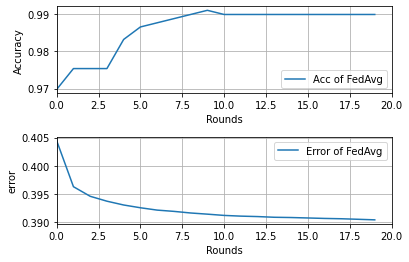

In [158]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)

s1 = np.array(all_results) #FedAvg

t = range(0,s1.shape[0])

ax1.plot(t, s1[:,0],label='Acc of FedAvg')
ax1.set_xlim(0,s1.shape[0])
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Accuracy')
ax1.grid(True)
ax1.legend()


ax2.plot(t, s1[:,1],label='Error of FedAvg')
ax2.set_xlim(0, s1.shape[0])
ax2.set_xlabel('Rounds')
ax2.set_ylabel('error')
ax2.grid(True)
ax2.legend()

plt.show()

